In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
# Create Spark session
spark = SparkSession.builder \
    .appName("BigDataProject") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.cores", "1") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-master:9000") \
    .config("spark.hadoop.hadoop.security.authentication", "simple") \
    .config("spark.hadoop.hadoop.security.authorization", "false") \
    .config("spark.master", "spark://spark-master:7077") \
    .getOrCreate()


In [3]:
# Try to load your dataset
try:
    df = spark.read.csv("hdfs://hadoop-master:9000/data/Metro_Interstate_Traffic_Volume.csv", 
                       header=True, 
                       inferSchema=True)
    print("\nSuccessfully loaded the dataset!")
    print("\nSchema:")
    df.printSchema()
    print("\nFirst 5 rows:")
    df.show(5)
except Exception as e:
    print(f"Error loading dataset: {str(e)}")


Successfully loaded the dataset!

Schema:
root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- traffic_volume: integer (nullable = true)


First 5 rows:
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|holiday|  temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|traffic_volume|
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|   None|288.28|    0.0|    0.0|        40|      Clouds|   scattered clouds|2012-10-02 09:00:00|          5545|
|   None|289.36|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 10:00:00|          

In [26]:
def save_to_parquet(df, filename):
    try:
        # Create a new directory for the output
        output_dir = f"hdfs://hadoop-master:9000/data/{filename}"
        
        # Save the DataFrame
        df.write \
          .mode("overwrite") \
          .option("user", "hadoop") \
          .parquet(output_dir)
        
        print(f"Successfully saved to {output_dir}")
    except Exception as e:
        print(f"Error saving to parquet: {str(e)}")

# Try saving
save_to_parquet(df, "traffic_data_v2.parquet")

# Verify the save
print("\nListing HDFS directory contents:")
files_df = spark.read.text("hdfs://hadoop-master:9000/data/")
files_df.show(truncate=False)

Successfully saved to hdfs://hadoop-master:9000/data/traffic_data_v2.parquet

Listing HDFS directory contents:
+-------------------------------------------------------------------------------------------------+
|value                                                                                            |
+-------------------------------------------------------------------------------------------------+
|holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume|
|None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545                          |
|None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516                             |
|None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767                           |
|None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026                           |
|None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918                    

In [5]:
# Save as CSV
def save_to_csv(df, filename):
    try:
        hdfs_path = f"hdfs://hadoop-master:9000/data/{filename}"
        df.write \
          .mode("overwrite") \
          .option("header", "true") \
          .csv(hdfs_path)
        print(f"Successfully saved to {hdfs_path}")
    except Exception as e:
        print(f"Error saving to CSV: {str(e)}")

# Save as CSV
save_to_csv(df, "traffic_data_processed_v2.csv")


Successfully saved to hdfs://hadoop-master:9000/data/traffic_data_processed_v2.csv


1. Préparation des Données et Stockage des Données :

In [27]:
from pyspark.sql.functions import col, when, log

# 1. Supprimer les lignes contenant des valeurs manquantes
df_cleaned = df.dropna()

# 2. Supprimer les doublons
df_cleaned = df_cleaned.dropDuplicates()

# 3. Ajouter une colonne pour le logarithme du volume de trafic
df_cleaned = df_cleaned.withColumn(
    "log_traffic_volume",
    when(col("traffic_volume") > 0, log(col("traffic_volume"))).otherwise(None)
)

# Afficher le résultat après nettoyage
print("\nData after cleaning and transformation:")
df_cleaned.show(5)

# Sauvegarder les données nettoyées dans un fichier CSV
def save_to_csv(df, filename):
    try:
        hdfs_path = f"hdfs://hadoop-master:9000/data/{filename}"
        df.write \
          .mode("overwrite") \
          .option("header", "true") \
          .csv(hdfs_path)
        print(f"Successfully saved cleaned data to {hdfs_path}")
    except Exception as e:
        print(f"Error saving to CSV: {str(e)}")

# Sauvegarder les données nettoyées
save_to_csv(df_cleaned, "traffic_data_cleaned_V2.csv")




Data after cleaning and transformation:
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+------------------+
|holiday|  temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|traffic_volume|log_traffic_volume|
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+------------------+
|   None|280.07|    0.0|    0.0|        90|        Rain|         light rain|2012-10-26 02:00:00|           326| 5.786897381366708|
|   None|275.67|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-11-05 01:00:00|          1299|   7.1693500166706|
|   None|283.15|    0.0|    0.0|        20|      Clouds|         few clouds|2012-11-10 12:00:00|          4762| 8.468423027046809|
|   None|273.12|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-11-29 12:00:00|          5081| 8.533263371593732|
|   None|272.56|    0.0|    0.0|        90

In [28]:
save_to_csv(df_cleaned, "traffic_data_cleaned_V2.csv")


Successfully saved cleaned data to hdfs://hadoop-master:9000/data/traffic_data_cleaned_V2.csv


2. Analyse Exploratoire des Données (EDA)

In [29]:
# Analyse exploratoire avec Spark SQL
df_cleaned.createOrReplaceTempView("traffic_data")

# Volume moyen de trafic par heure
hourly_avg_traffic = spark.sql("""
    SELECT hour(date_time) AS hour, AVG(traffic_volume) AS avg_traffic_volume
    FROM traffic_data
    GROUP BY hour
    ORDER BY hour
""")
print("\nAverage traffic volume by hour:")
hourly_avg_traffic.show()

# Sauvegarder les résultats en CSV
#save_to_csv(hourly_avg_traffic, "hourly_avg_traffic.csv")

# Identifier les jours avec les volumes de trafic les plus élevés
high_traffic_days = spark.sql("""
    SELECT date(date_time) AS date, SUM(traffic_volume) AS total_traffic
    FROM traffic_data
    GROUP BY date
    ORDER BY total_traffic DESC
    LIMIT 10
""")
print("\nDays with highest traffic:")
high_traffic_days.show()

# Sauvegarder les résultats
#save_to_csv(high_traffic_days, "high_traffic_days.csv")



Average traffic volume by hour:
+----+------------------+
|hour|avg_traffic_volume|
+----+------------------+
|   0| 834.9847740667976|
|   1| 516.3390327308256|
|   2|388.35364041604754|
|   3| 371.0908641975309|
|   4| 702.5518890483022|
|   5| 2094.573436742608|
|   6| 4140.503593675132|
|   7| 4740.181337181337|
|   8| 4587.497115384615|
|   9| 4385.277502477701|
|  10| 4184.135838150289|
|  11| 4465.569230769231|
|  12| 4718.031729785056|
|  13|4714.6528361344535|
|  14| 4931.888776028441|
|  15| 5240.459906880496|
|  16| 5663.756539235413|
|  17| 5310.076047594413|
|  18| 4263.563792233989|
|  19|3275.2064384261625|
+----+------------------+
only showing top 20 rows


Days with highest traffic:
+----------+-------------+
|      date|total_traffic|
+----------+-------------+
|2018-08-24|       257191|
|2017-05-01|       248731|
|2018-09-20|       231772|
|2015-07-06|       226086|
|2017-10-27|       223543|
|2013-04-12|       222995|
|2013-12-03|       221122|
|2018-09-04|       

3. Modélisation et Analyse avec Spark MLlib

Clustering avec K-Means

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Préparer les données pour le clustering
assembler = VectorAssembler(inputCols=["traffic_volume", "temp"], outputCol="features")
df_features = assembler.transform(df_cleaned)

# Appliquer K-Means
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_features)
predictions = model.transform(df_features)

# Afficher les clusters
print("\nClusters:")
predictions.select("traffic_volume", "temp", "prediction").show(5)

# Sauvegarder les résultats en CSV
#save_to_csv(predictions, "traffic_clusters.csv")



Clusters:
+--------------+------+----------+
|traffic_volume|  temp|prediction|
+--------------+------+----------+
|           326|280.07|         0|
|          1299|275.67|         0|
|          4762|283.15|         2|
|          5081|273.12|         2|
|          3293|272.56|         1|
+--------------+------+----------+
only showing top 5 rows



Régression Linéaire pour Prédire le Trafic


In [31]:
from pyspark.ml.regression import LinearRegression

# Préparer les données pour la régression
assembler = VectorAssembler(inputCols=["temp", "rain_1h"], outputCol="features")
df_features = assembler.transform(df_cleaned).select("features", "traffic_volume")

# Modèle de régression
lr = LinearRegression(featuresCol="features", labelCol="traffic_volume")
lr_model = lr.fit(df_features)

# Résultats de la régression
print("\nRegression coefficients:", lr_model.coefficients)
print("\nIntercept:", lr_model.intercept)

# Sauvegarder les coefficients en CSV
coefficients = [(float(x),) for x in lr_model.coefficients.toArray()]
coefficients_df = spark.createDataFrame(coefficients, ["Coefficient"])
#save_to_csv(coefficients_df, "regression_coefficients.csv")



Regression coefficients: [19.384201897703345,0.15678259907035563]

Intercept: -2191.3686797819287


5. Visualisation des Résultats

Charger un Fichier CSV dans Jupyter

In [34]:
import pandas as pd

# Charger les fichiers CSV
hourly_avg_traffic = pd.read_csv("hourly_avg_traffic.csv")
high_traffic_days = pd.read_csv("high_traffic_days.csv")
traffic_data_cleaned = pd.read_csv("traffic_data_cleaned.csv")
traffic_data_processed_v2 = pd.read_csv("traffic_data_processed_v2.csv")
regression_coefficients = pd.read_csv("regression_coefficients.csv")

# Aperçu des données
print("Aperçu de hourly_avg_traffic :")
print(hourly_avg_traffic.head())

print("\nAperçu de high_traffic_days :")
print(high_traffic_days.head())

print("\nAperçu de traffic_data_cleaned :")
print(traffic_data_cleaned.head())

print("\nAperçu de traffic_data_processed_v2 :")
print(traffic_data_processed_v2.head())

print("\nAperçu de regression_coefficients :")
print(regression_coefficients.head())


Aperçu de hourly_avg_traffic :
   hour  avg_traffic_volume
0     0          834.984774
1     1          516.339033
2     2          388.353640
3     3          371.090864
4     4          702.551889

Aperçu de high_traffic_days :
         date  total_traffic
0  2018-08-24         257191
1  2017-05-01         248731
2  2018-09-20         231772
3  2015-07-06         226086
4  2017-10-27         223543

Aperçu de traffic_data_cleaned :
  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  280.07      0.0      0.0          90         Rain   
1     NaN  275.67      0.0      0.0          75       Clouds   
2     NaN  283.15      0.0      0.0          20       Clouds   
3     NaN  273.12      0.0      0.0          75       Clouds   
4     NaN  272.56      0.0      0.0          90       Clouds   

  weather_description                 date_time  traffic_volume  \
0          light rain  2012-10-26T02:00:00.000Z             326   
1       broken clouds  2012-11-05T01:00:00.

1. Visualisation des Moyennes Horaires du Trafic

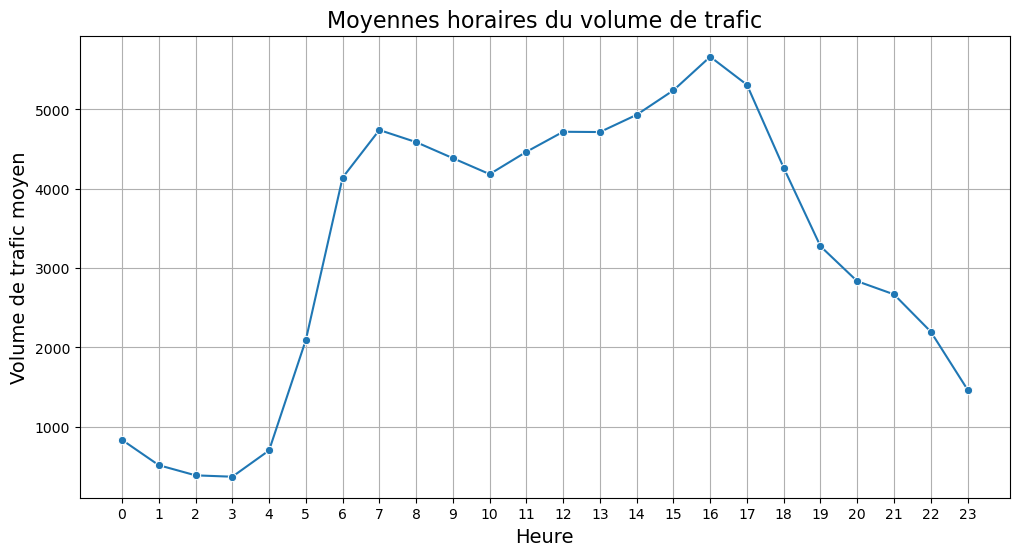

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg_traffic, x="hour", y="avg_traffic_volume", marker="o")
plt.title("Moyennes horaires du volume de trafic", fontsize=16)
plt.xlabel("Heure", fontsize=14)
plt.ylabel("Volume de trafic moyen", fontsize=14)
plt.xticks(range(0, 24))
plt.grid()
plt.show()


2. Visualisation des Jours à Fort Trafic


/tmp/ipykernel_311/3840960082.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_traffic_days, x="date", y="total_traffic", palette="viridis")


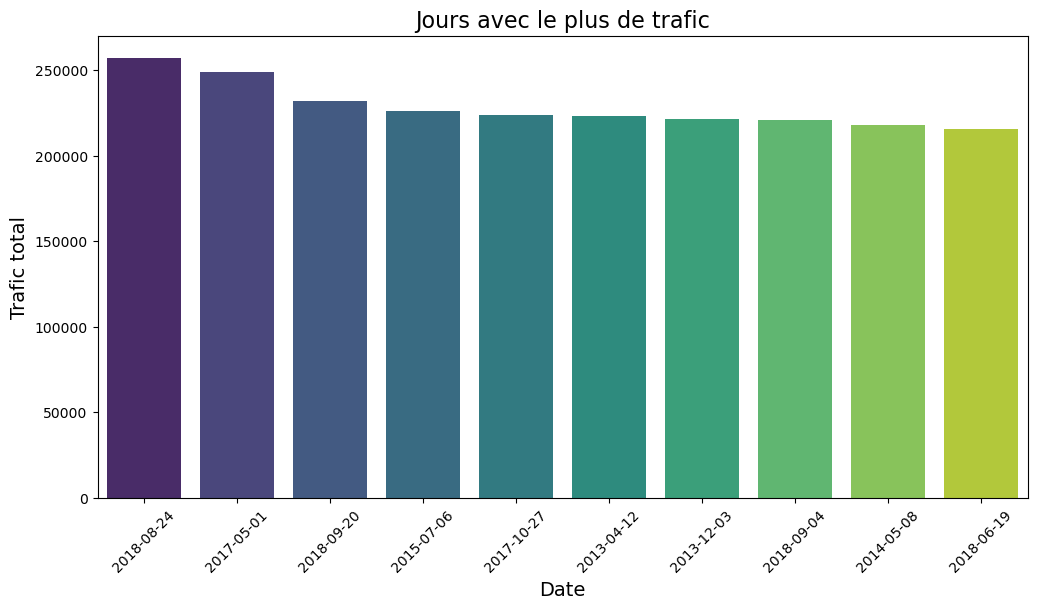

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(data=high_traffic_days, x="date", y="total_traffic", palette="viridis")
plt.title("Jours avec le plus de trafic", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trafic total", fontsize=14)
plt.xticks(rotation=45)
plt.show()


3. Analyse des Clusters de Trafic


In [39]:
from sklearn.cluster import KMeans
import pandas as pd

# Choisir les colonnes pour le clustering
data_for_clustering = traffic_data_processed_v2[['temp', 'traffic_volume']].dropna()

# Appliquer K-Means avec 3 clusters (tu peux ajuster le nombre de clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
traffic_data_processed_v2['cluster'] = kmeans.fit_predict(data_for_clustering)

# Vérifier les premières lignes avec la nouvelle colonne
print(traffic_data_processed_v2.head())


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description                 date_time  traffic_volume  cluster  
0    scattered clouds  2012-10-02T09:00:00.000Z            5545        0  
1       broken clouds  2012-10-02T10:00:00.000Z            4516        0  
2     overcast clouds  2012-10-02T11:00:00.000Z            4767        0  
3     overcast clouds  2012-10-02T12:00:00.000Z            5026        0  
4       broken clouds  2012-10-02T13:00:00.000Z            4918        0  


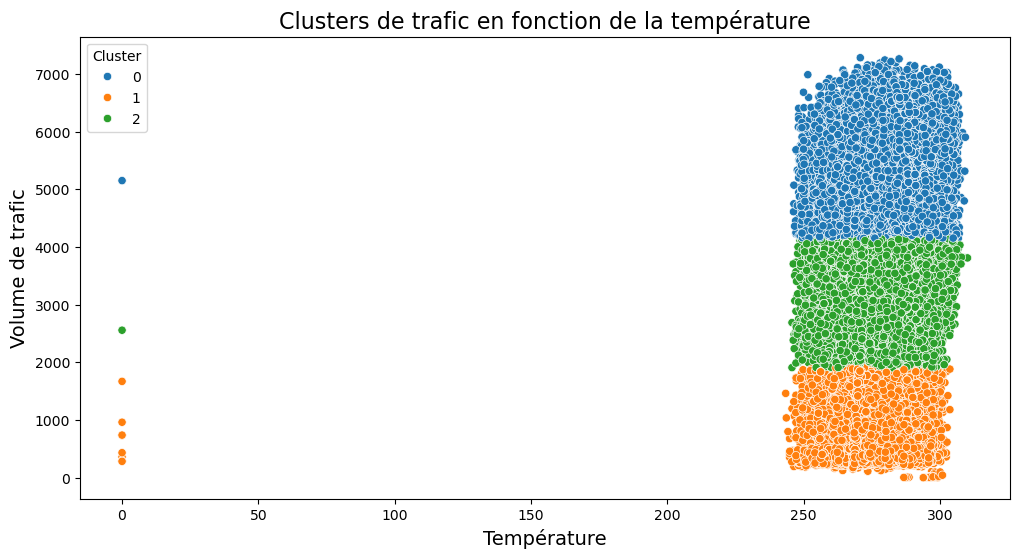

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=traffic_data_processed_v2, x="temp", y="traffic_volume", hue="cluster", palette="tab10")
plt.title("Clusters de trafic en fonction de la température", fontsize=16)
plt.xlabel("Température", fontsize=14)
plt.ylabel("Volume de trafic", fontsize=14)
plt.legend(title="Cluster")
plt.show()


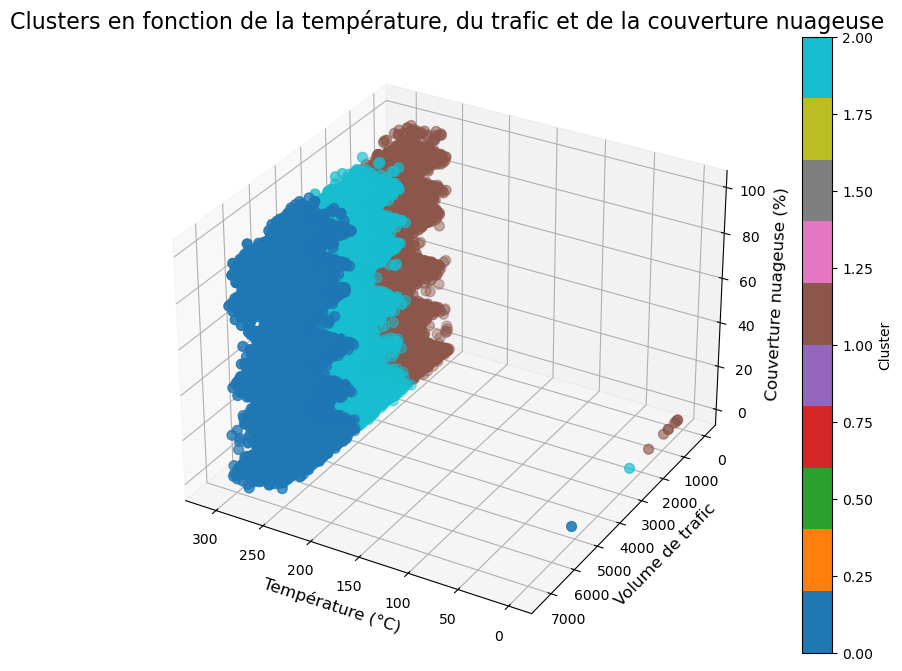

In [41]:
# Importation des bibliothèques nécessaires
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Création d'un graphique 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot 3D avec les clusters
scatter = ax.scatter(
    traffic_data_processed_v2['temp'],           # Axe X : Température
    traffic_data_processed_v2['traffic_volume'], # Axe Y : Volume de trafic
    traffic_data_processed_v2['clouds_all'],     # Axe Z : Couverture nuageuse
    c=traffic_data_processed_v2['cluster'],      # Couleurs par cluster
    cmap='tab10',                                # Palette de couleurs
    s=50                                         # Taille des points
)

# Ajout des titres et des étiquettes
ax.set_title("Clusters en fonction de la température, du trafic et de la couverture nuageuse", fontsize=16)
ax.set_xlabel("Température (°C)", fontsize=12)
ax.set_ylabel("Volume de trafic", fontsize=12)
ax.set_zlabel("Couverture nuageuse (%)", fontsize=12)

# Ajout d'une légende des clusters
plt.colorbar(scatter, ax=ax, label="Cluster")

# Ajustement des angles de vue
ax.view_init(elev=30, azim=120)  # Change `elev` et `azim` pour ajuster l'angle

# Affichage du graphique
plt.show()


4. Visualisation des Coefficients de Régression

/tmp/ipykernel_311/3094889089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regression_coefficients, x="Variable", y="Coefficient", palette="coolwarm")


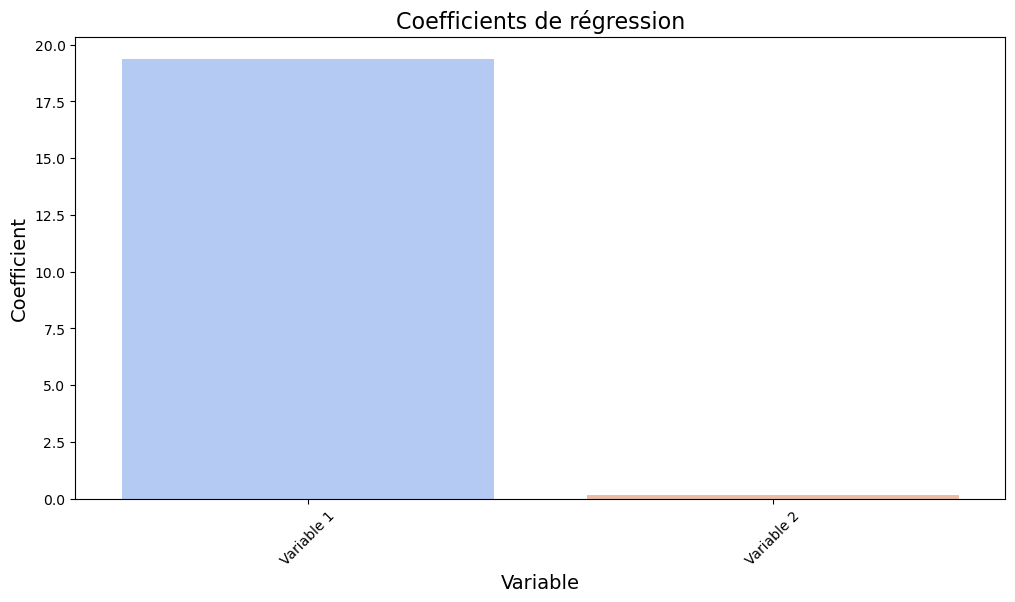

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=regression_coefficients, x="Variable", y="Coefficient", palette="coolwarm")
plt.title("Coefficients de régression", fontsize=16)
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Coefficient", fontsize=14)
plt.xticks(rotation=45)
plt.show()


5. Distribution des Volumes de Trafic

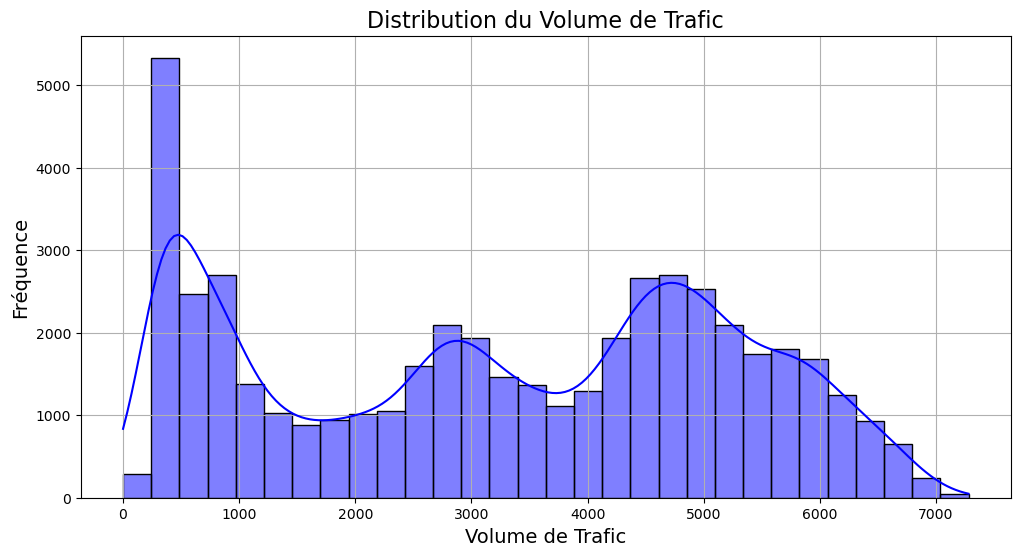

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramme du volume de trafic
plt.figure(figsize=(12, 6))
sns.histplot(traffic_data_processed_v2['traffic_volume'], kde=True, color="blue", bins=30)
plt.title("Distribution du Volume de Trafic", fontsize=16)
plt.xlabel("Volume de Trafic", fontsize=14)
plt.ylabel("Fréquence", fontsize=14)
plt.grid(True)
plt.show()


6. Comparaison du Trafic par Jour de la Semaine


/tmp/ipykernel_311/4191590413.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


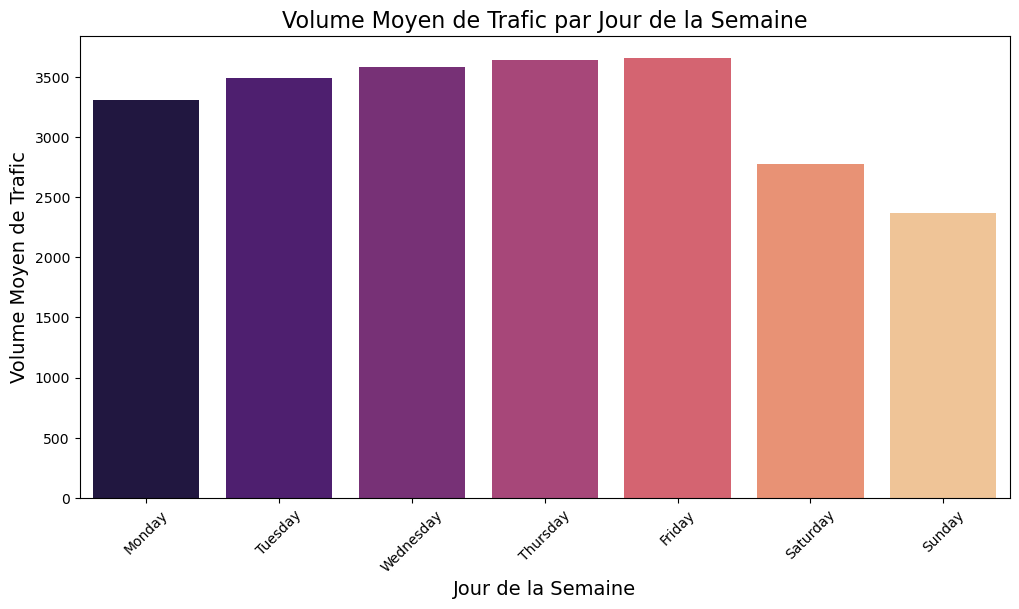

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la colonne 'date_time' en objet datetime
traffic_data_processed_v2['date_time'] = pd.to_datetime(traffic_data_processed_v2['date_time'])

# Ajouter une colonne pour le jour de la semaine
traffic_data_processed_v2['day_of_week'] = traffic_data_processed_v2['date_time'].dt.day_name()

# Calculer le trafic moyen par jour de la semaine
avg_traffic_by_day = traffic_data_processed_v2.groupby('day_of_week')['traffic_volume'].mean().reset_index()

# Tracer un graphique en barres pour le trafic moyen par jour de la semaine
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_traffic_by_day,
    x='day_of_week',
    y='traffic_volume',
    palette="magma",
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.title("Volume Moyen de Trafic par Jour de la Semaine", fontsize=16)
plt.xlabel("Jour de la Semaine", fontsize=14)
plt.ylabel("Volume Moyen de Trafic", fontsize=14)  # Ici, la chaîne est bien fermée
plt.xticks(rotation=45)
plt.show()
